# Stationary Solution with Variable Conductivity and Heat Production

In this example we will examine how to calculate steady-state geothermin layered crust. We will use simple three layer structure of the crust.

  * Upper crust 15km, $\lambda$=2.5 Wm-1K-1, $H$=1e-6 Wm-3
  * Middle crust 10km, $\lambda$=2.3 Wm-1K-1, no heat production
  * Lower crust 10km, $\lambda$=2.1 Wm-1K-1, no heat production

As the conductivity and heat production is no more constant, we need to store then in arrays. Based on our staggered grid design, those arrays are 1 element smaller comparing to calculation grid.


In [15]:
from typing import Union, NewType


from numpy import array, hstack, linspace, exp, sum, interp
from numpy.typing import ArrayLike 

from scipy.sparse import spdiags
from scipy.sparse.linalg import spsolve


from matplotlib.pyplot import figure, plot, xlabel, ylabel, title, style

style.use('seaborn-bright')

In [5]:
T0 = 0                       # surface temperature
th = 35000                   # thickness of the crust
n = 351                      # number of nodes
dx = th / (n - 1)              # node spacing
x = linspace(0, 35000, n)  # calculation grid positions
q = -32e-3                   # mantle heat flow

We need to create material properties arrays. We will use Python list multiplification trick. Note that node spacing is 100.

In [6]:
k = array(150 * [2.5] + 100 * [2.3] + 100*[2.1])  # conductivities 
H = array(150 * [1e-6] + 200 * [0])               # heat productions

xm = (x[:-1] + x[1:])/2                           # material grid positions (in between nodes)

$$
\begin{vmatrix}
1&0&0&0&0&0\\
{{\lambda _0}}&{ - \left( {{\lambda _0} + {\lambda _1}} \right)}&{{\lambda _1}}&0&0&0\\
0&{{\lambda _1}}&{ - \left( {{\lambda _1} + {\lambda _2}} \right)}&{{\lambda _2}}&0&0\\
 \vdots & \vdots & \vdots & \vdots & \vdots & \vdots \\
0&0&0&{{\lambda _{n - 3}}}&{ - \left( {{\lambda _{n - 3}} + {\lambda _{n - 2}}} \right)}&{{\lambda _{n - 2}}}\\
0&0&0&0&{2 {\lambda _{n - 2}}}&{- 2 {\lambda _{n - 2}}}
\end{vmatrix} \cdot \begin{vmatrix}
   {T_{0}}  \\
   {T_{1}}  \\
   {T_{2}}  \\
    \vdots   \\
   {T_{n - 2}}  \\
   {T_{n-1}}  \\
\end{vmatrix} = \begin{vmatrix}
{{T_{def}}}\\
{ - \Delta {x^2} \cdot \frac{{{H_0} + {H_1}}}{2}}\\
{ - \Delta {x^2} \cdot \frac{{{H_1} + {H_2}}}{2}}\\
 \vdots \\
{ - \Delta {x^2} \cdot \frac{{{H_{n - 3}} + {H_{n - 2}}}}{2}}\\
{q \cdot 2 \Delta x - H_{n - 2} \cdot \Delta {x^2}}
\end{vmatrix}
$$

In [7]:
kl, kr = k[:-1], k[1:]
Hl, Hr = H[:-1], H[1:]

# Diagonals including boundary conditions.
dl = hstack((kl, 2 * k[-1], 0))
dr = hstack((0, 0, kr))
dm = hstack((1, -(kl + kr), -2*k[-1]))

# Sparse coefficient matrix
A = spdiags([dl, dm, dr], [-1, 0, 1], n, n, 'csr')

# Column vector of constant terms and boundary conditions.
b = hstack((T0, -(Hl + Hr) * dx**2 / 2, 2 * q * dx - H[-1] * dx**2))

T = spsolve(A, b)

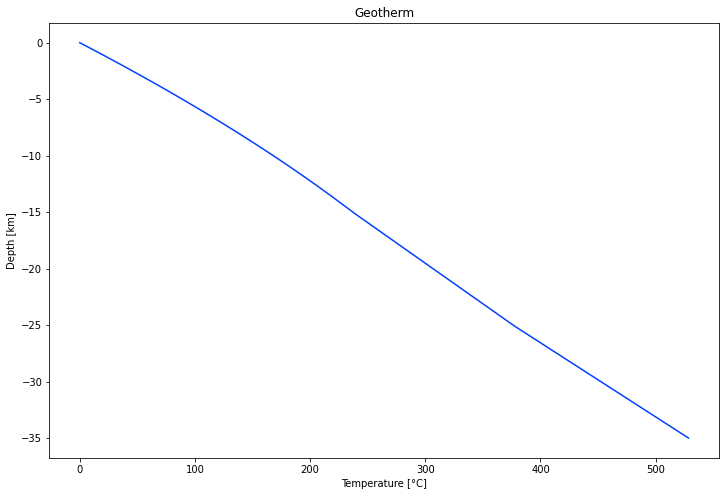

In [8]:
figure(figsize=(12, 8))
plot(T, -x/1000)
xlabel('Temperature [°C]')
ylabel('Depth [km]')
title('Geotherm');

## Homework Exercise 1

Calculate stable geotherm for exponential distribution of heat production proposed by *Lachenbruch, 1968*:

$$H(z) = H_0\exp\left(\frac{-z}{D}\right)$$

where $H_0$ = 2 μWm-3 is surface heat production and $D$ (we will use 10000 m) is characteristic thickness and $z$ is depth in metres.

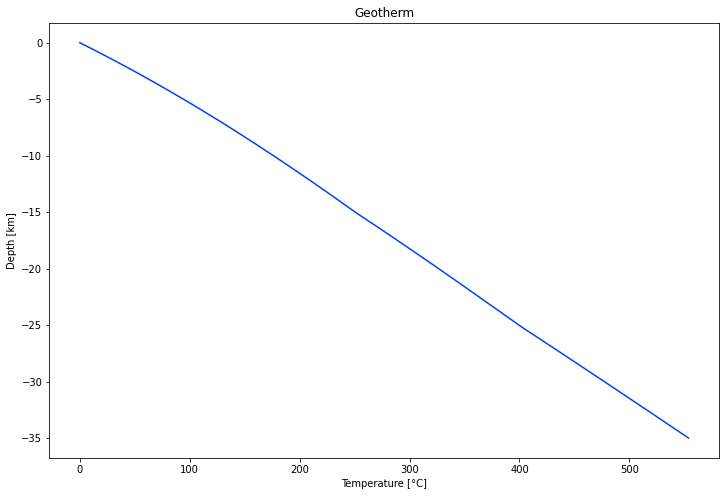

In [11]:
def Lachenbruch(zs: ArrayLike, H0, D) -> ArrayLike:
    return H0 * exp(-zs / D)    


H = Lachenbruch(zs=xm, H0=2e-6, D=10_000)

Hl, Hr = H[:-1], H[1:]

b = hstack((T0, -(Hl + Hr) * dx**2 / 2, 2 * q * dx - H[-1] * dx**2))

T = spsolve(A, b)

figure(figsize=(12, 8))
plot(T, -x/1000)
xlabel('Temperature [°C]')
ylabel('Depth [km]')
title('Geotherm');


## Homework Exercise 2

Calculate stable geotherm for thermal conductivity given by equation:

$$\lambda=2+ e^{ \left ( \frac{-T}{1250} \right )}+\frac{48}{e^ {\left ( \frac{1250-T}{10} \right )}}$$

and same heat production distribution as in previous exercise.

**NOTE 1: You need to know the temperature, to calculate conductivity, but you need to know conductivity to calculate temperature**

One of the possibilities how to calculate it is to start with some conductivity (e.g. as in previous exercise), calculate temperature, than use it to recalculate conductivities and calculate temperature again. You can repeat it, until there is no significant change in conductivity between individual calcualtions. We call such methods **iterative**.

**NOTE 2: To get correct temperatures to be used in equation, you need to find temperatures on material grid nodes (variable xm). Use function interp**

In [12]:
calculate_conductivity = lambda T: (2 + exp(-T/1250)) + (48 / exp((1250 - T)/10))

# Starting conductivities.
k = array(350 * [2.5])  
kl, kr = k[:-1], k[1:]

# Diagonals including boundary conditions.
dl = hstack((kl, 2 * k[-1], 0))
dr = hstack((0, 0, kr))
dm = hstack((1, -(kl + kr), -2 * k[-1]))

# Sparse coefficient matrix.
A = spdiags([dl, dm, dr], [-1, 0, 1], n, n, 'csr')

# Column vector of constant terms and boudanry conditions.
b = hstack((T0, -(Hl + Hr) * dx**2 / 2, 2 * q * dx - H[-1] * dx**2))

In [16]:
T_ = spsolve(A, b)
k_ = calculate_conductivity(interp(xm , x, T_)) # < ZDE MUSÍM INTERPOLOVAT

Text(0.5, 1.0, 'Depth vs Conductivity')

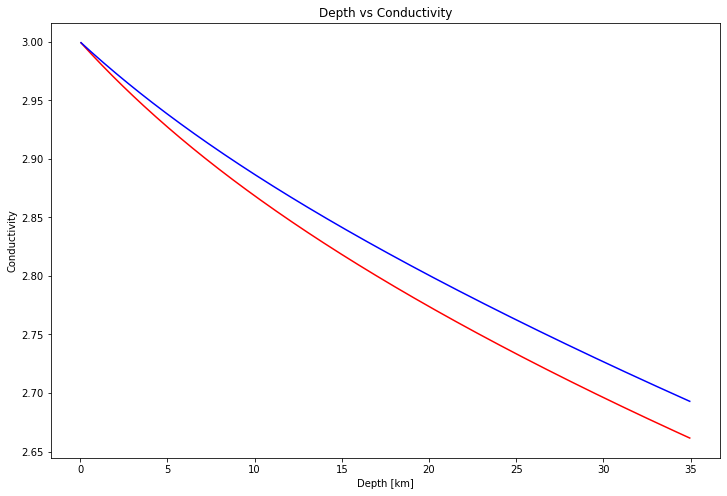

In [18]:
# Calculate new conductivities (iterative method).

Tn = T_.copy() # _n as new, _o as old
kn = k_.copy() 

error = 10_000

while error > 1:
    # print(error)
    kl, kr = kn[:-1], kn[1:]

    dl = hstack((kl, 2 * kn[-1], 0))
    dr = hstack((0, 0, kr))
    dm = hstack((1, -(kl + kr), -2 * kn[-1]))

    A = spdiags([dl, dm, dr], [-1, 0, 1], n, n, 'csr')

    ko = kn.copy()

    Tn = spsolve(A, b)
    kn = calculate_conductivity(interp(xm , x, Tn)) # < ZDE MUSÍM INTERPOLOVAT

    error = sum((ko - kn)** 2)

# Plot the result.
figure(figsize=(12, 8))
plot(xm / 1000, k_, 'r-')
plot(xm / 1000, kn, 'b-')
ylabel('Conductivity')
xlabel('Depth [km]')
title('Depth vs Conductivity')

Text(0.5, 1.0, 'Temperature vs Depth')

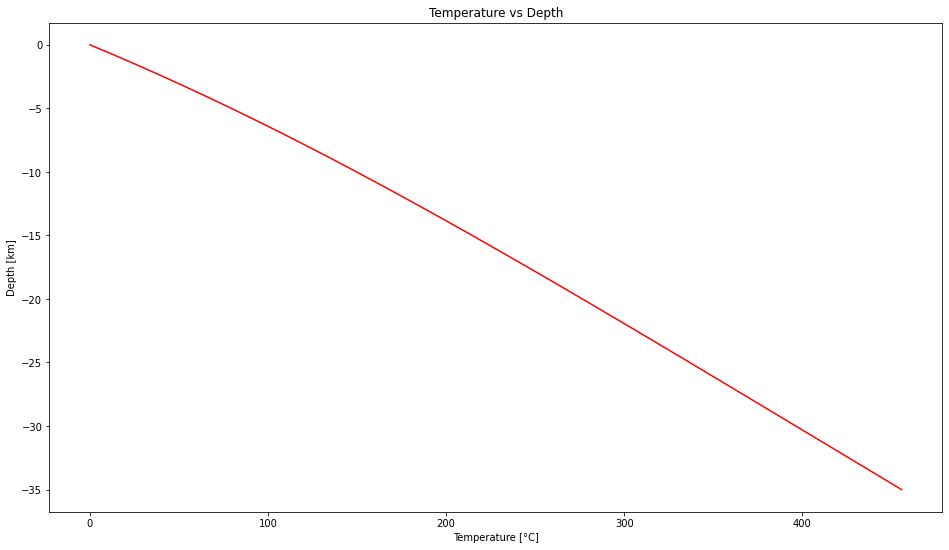

In [19]:
# #################################################################
# Calulate the stable geotherm
# #################################################################

kl, kr = kn[:-1], kn[1:]

dl = hstack((kl, 2 * kn[-1], 0))
dr = hstack((0, 0, kr))
dm = hstack((1, -(kl + kr), -2 * kn[-1]))

A = spdiags([dl, dm, dr], [-1, 0, 1], n, n, 'csr')

Ts = spsolve(A, b) # stable

# Plot the result.
figure(figsize=(16, 9))
plot(Ts, -x / 1000, 'r-')
xlabel('Temperature [°C]')
ylabel('Depth [km]')
title('Temperature vs Depth')

## Homework exercise 3
Experimental measurements of thermal diffusivity $\kappa$ of metamorphic rocks (*Nabelek, 2010*) results in following approximation:

$$\kappa(T)=1.214\cdot 10^{-6}\times \exp \left ( \frac{-T}{285.2} \right )+3.19\cdot 10^{-7}$$

Temperature dependence of heat capacity for these rocks have been defined by *Whittington (2009)* as:

$$c(T)=726+1.53\times T-1.6\cdot 10^{-3}\times T^2+6.64\cdot 10^{-7}\times T^3$$

These equations could be used to express thermal conductivity as:

$$\lambda(T)=\rho \cdot c(T) \cdot \kappa(T)$$

where for density $\rho$ we will use value 2750 kg.m^{-3}.

  1. Calculate stable geotherm using these equations (You will have to use iterative method as well).
  2. plot resulting conductivity vs. depth
  3. plot resulting heat capacity vs. depth

10000


Text(0.5, 1.0, 'Heat capacity vs Depth')

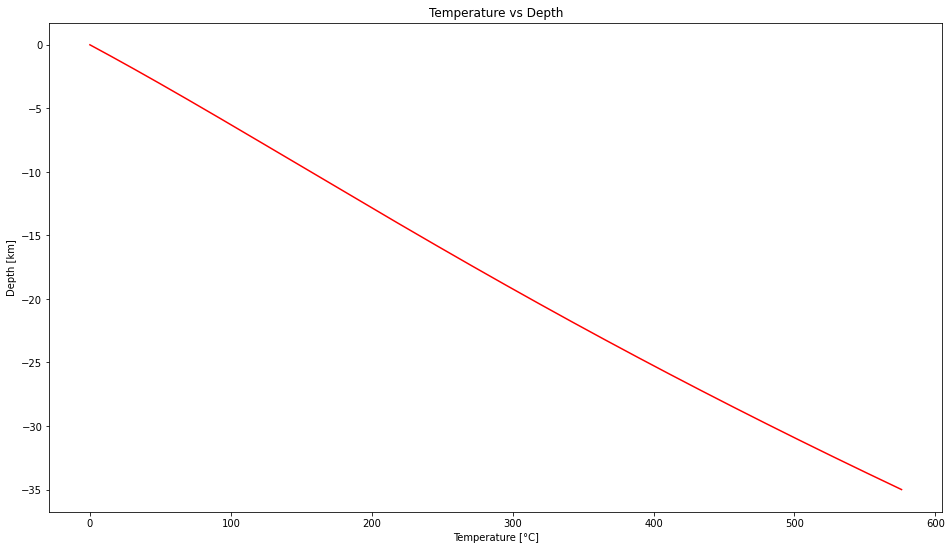

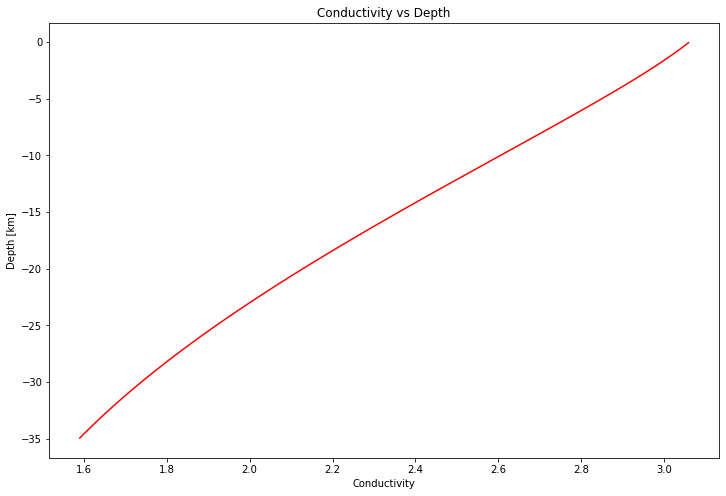

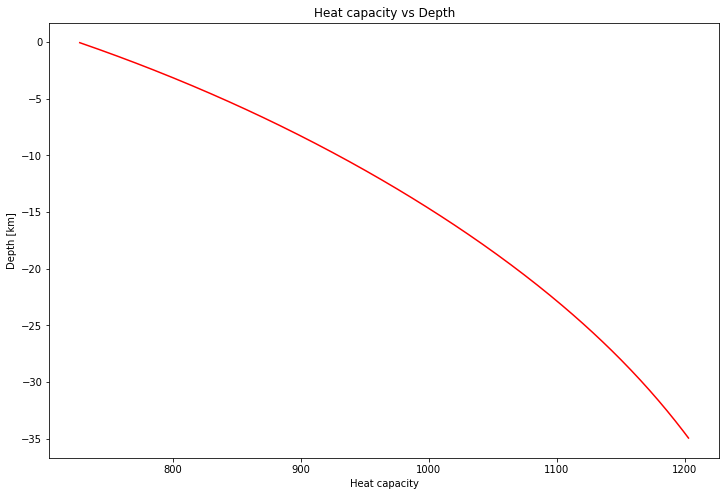

In [23]:
Temperature = NewType("Temperature", float)
Diffusivity = NewType("Diffusivity", float)


def Nabelek(T: ArrayLike) ->  Diffusivity: # or array od Diffusivity
    return 1.214e-6 * exp(-T/285.2) + 3.19e-7


def Whittington(T: ArrayLike): # -> # or array od Diffusivity Capacity
    return 726 + 1.53 * T - 1.6e-3 * T**2 + 6.64e-7 * T**3


def Lambda(T: ArrayLike, rho: float = 2750.0): # -> # or array od Conductivity
    return rho * Whittington(T) * Nabelek(T)


# ############################################################################
# 1 Calculate stable geotherm
# ############################################################################

# Starting conductivities.
k = array(350 * [2.5])  
kl, kr = k[:-1], k[1:]

# Diagonals including boundary conditions.
dl = hstack((kl, 2 * k[-1], 0))
dr = hstack((0, 0, kr))
dm = hstack((1, -(kl + kr), -2 * k[-1]))

# Sparse coefficient matrix.
A = spdiags([dl, dm, dr], [-1, 0, 1], n, n, 'csr')

# Column vector of constant terms and boudanry conditions.
b = hstack((T0, -(Hl + Hr) * dx**2 / 2, 2 * q * dx - H[-1] * dx**2))

T_ = spsolve(A, b)
k_ = Lambda(interp(xm , x, T_)) # < ZDE MUSÍM INTERPOLOVAT
c_ = Whittington(interp(xm , x, T_))

# Calculate new conductivities (iterative method).

Tn = T_.copy() # _n as new, _o as old
kn = k_.copy() 
cn = c_.copy()

error = 10_000

while error > 1:
    print(error)

    kl, kr = kn[:-1], kn[1:]

    dl = hstack((kl, 2 * kn[-1], 0))
    dr = hstack((0, 0, kr))
    dm = hstack((1, -(kl + kr), -2 * kn[-1]))

    A = spdiags([dl, dm, dr], [-1, 0, 1], n, n, 'csr')

    ko = kn.copy()

    Tn = spsolve(A, b)
    kn = Lambda(interp(xm , x, Tn), rho=2750) # < ZDE MUSÍM INTERPOLOVAT
    cn = Whittington(interp(xm , x, Tn))

    error = sum((ko - kn)** 2)

# ############################################################################
# Bonus: Plot stable geotherm
# ############################################################################
# Plot the result.
figure(figsize=(16, 9))
plot(Tn, -x / 1000, 'r-')
xlabel('Temperature [°C]')
ylabel('Depth [km]')
title('Temperature vs Depth')

# ############################################################################
# 2. Plot conductivity vs depth
# ############################################################################

figure(figsize=(12, 8))
plot(kn, -xm / 1000, 'r-')
xlabel('Conductivity')
ylabel('Depth [km]')
title('Conductivity vs Depth')

# ############################################################################
# 3. Plot heat capacity vs depth
# ############################################################################

figure(figsize=(12, 8))
plot(cn, -xm / 1000, 'r-')
xlabel('Heat capacity')
ylabel('Depth [km]')
title('Heat capacity vs Depth')

In [ ]:
np.__version__
